<a href="https://colab.research.google.com/github/AtharvaNamdeoKV2004/PCSE25-16/blob/main/Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

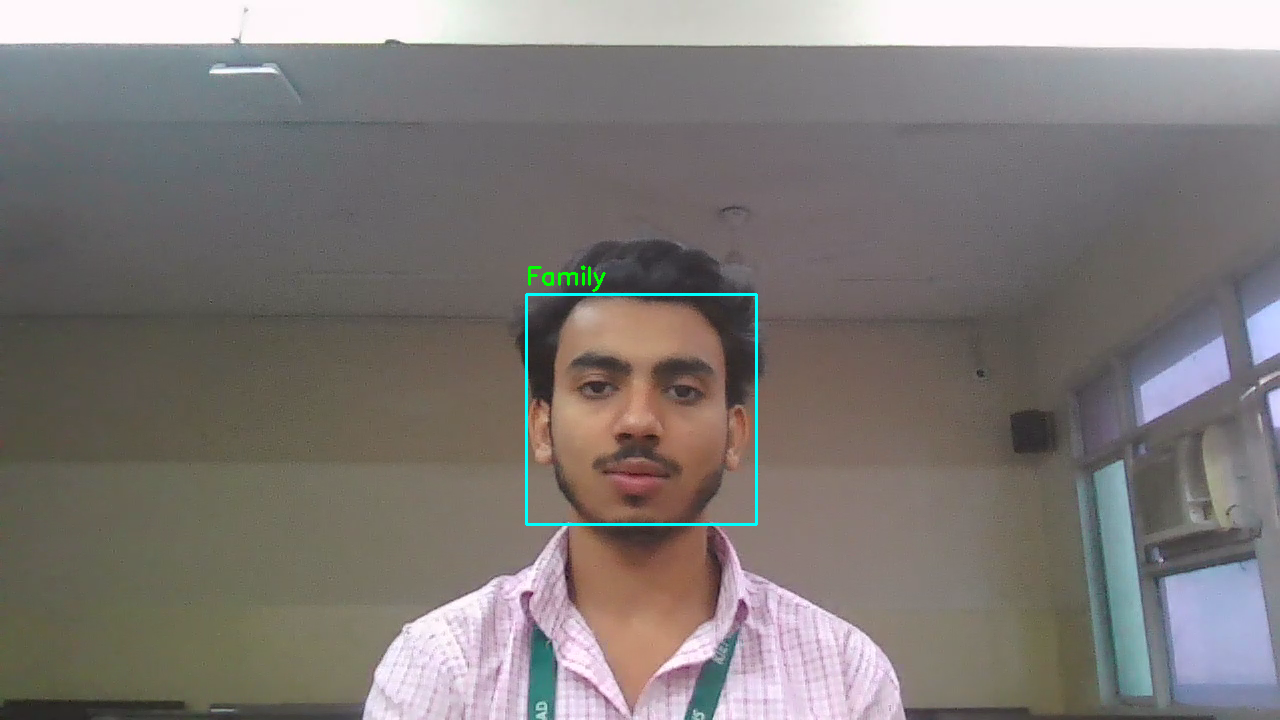

In [24]:
# Install required packages (Colab only - first run)
!pip install -q ultralytics
!pip install -q deepface
!pip install -q opencv-python-headless

# Import libraries
import cv2
import os
import numpy as np
from deepface import DeepFace
from ultralytics import YOLO
from IPython.display import display, clear_output
from PIL import Image
import time

# Load YOLOv5 model
model = YOLO('yolov8n.pt')  # You can replace with yolov8s.pt or yolov8m.pt for better accuracy

# Harmful object labels
harmful_objects = ['knife', 'gun']  # Adjust based on YOLO model labels

# Load family member embeddings
family_embeddings = []
family_dir = 'family_faces'  # Upload this folder in Colab with known family member images

for img_name in os.listdir(family_dir):
    img_path = os.path.join(family_dir, img_name)
    try:
        embedding = DeepFace.represent(img_path=img_path, model_name='VGG-Face')[0]["embedding"]
        family_embeddings.append(embedding)
    except:
        print(f"Face not found in {img_name}")

# Helper function to match face with family dataset
from deepface import DeepFace

def is_family_member(face_img_path):
    try:
        for known_face in os.listdir(family_dir):
            if not known_face.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            known_path = os.path.join(family_dir, known_face)

            result = DeepFace.verify(img1_path=known_path, img2_path=face_img_path, model_name='VGG-Face', enforce_detection=False)

            if result["verified"]:  # DeepFace automatically checks distance & threshold
                print(f"Matched with {known_face}, Distance: {result['distance']:.2f}")
                return True
    except Exception as e:
        print(f"Error in face match: {e}")
    return False


# Function to simulate alarm
def trigger_alarm():
    print("🚨 Intruder with weapon detected! Triggering Alarm!")
    # You can play a beep using IPython.display.Audio in Colab or integrate buzzer in real-world apps
frame = cv2.imread("ManWithGun.jpeg")

#cap = cv2.VideoCapture("test.mp4")
  # Use 0 for webcam, or provide video path

print("🔍 Starting Surveillance...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Object detection
    results = model(frame, verbose=False)[0]
    harmful_found = False

    for r in results.boxes.data.tolist():
        x1, y1, x2, y2, score, cls = map(int, r[:6])
        label = model.names[cls]
        if label in harmful_objects:
            harmful_found = True
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    non_family_detected = False

    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)

        # Save temp face image
        face_path = 'temp_face.jpg'
        cv2.imwrite(face_path, face_img)

        if not is_family_member(face_path):
            non_family_detected = True
            cv2.putText(frame, "Unknown", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        else:
            cv2.putText(frame, "Family", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Trigger alarm condition
    if harmful_found and non_family_detected:
        trigger_alarm()

    # Display the frame
    clear_output(wait=True)
    display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

    # To break manually, press ESC (in real apps you can set key break)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()
